# Outline

* Today we will show how to train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions

# To perform well, we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [1]:
% run plot_conf.py

In [2]:
plt_style()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [4]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

Processing...
Done!


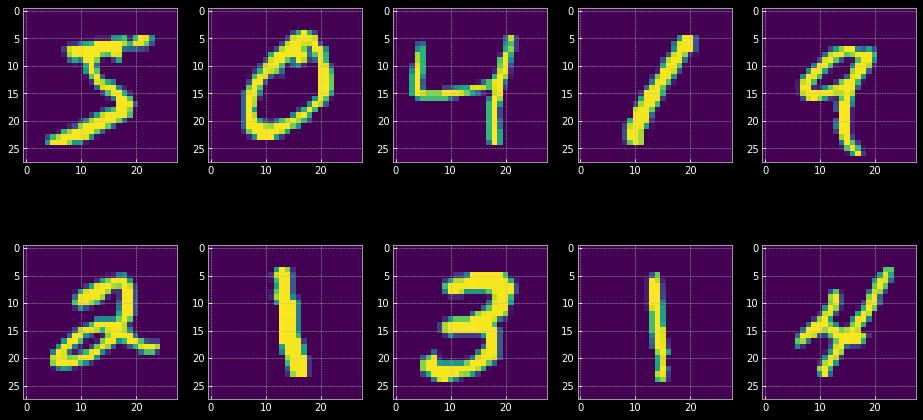

In [5]:
# show some images
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())

# Create the model classes

In [6]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
 


## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
  
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
            
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [9]:
n_hidden    = 8    # number of hidden units

model = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model)
    test(model)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298159
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.548613
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.037652
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.726803
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.509063
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.557210
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.552168
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.653770
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.472309
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.312553

Test set: Average loss: 0.3916, Accuracy: 8838/10000 (88%)



# Train a ConvNet with the same number of parameters

In [10]:
# Training settings 
n_features    = 6     # number of feature maps

model = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model)
    test(model)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.312525
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.367853
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.553439
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.517068
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.329667
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.253772
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.319146
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.318496
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.152777
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.308449

Test set: Average loss: 0.1812, Accuracy: 9429/10000 (94%)



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


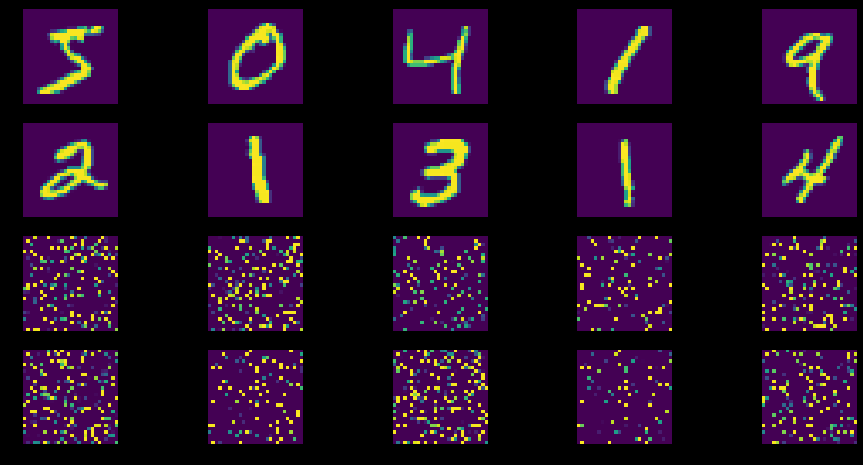

In [11]:
perm = torch.randperm(784)
plt.figure()
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [12]:
# Training settings 
n_features    = 6     # number of feature maps

model = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model, perm)
    test(model, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310434
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.240858
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.168054
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.010057
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.646327
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.255659
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.689564
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.787074
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.410533
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.748124

Test set: Average loss: 0.5393, Accuracy: 8318/10000 (83%)



# Fully-Connected with Permuted Pixels

In [13]:
n_hidden    = 8    # number of hidden units

model = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model, perm)
    test(model, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290806
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.952408
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.314324
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.943623
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.733767
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.561163
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.816121
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.495037
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.709446
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.529315

Test set: Average loss: 0.4864, Accuracy: 8513/10000 (85%)



# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

In [17]:
print(accuracy_list)

[88.38, 94.29, 83.18, 85.13]


TypeError: unsupported operand type(s) for -: 'str' and 'float'

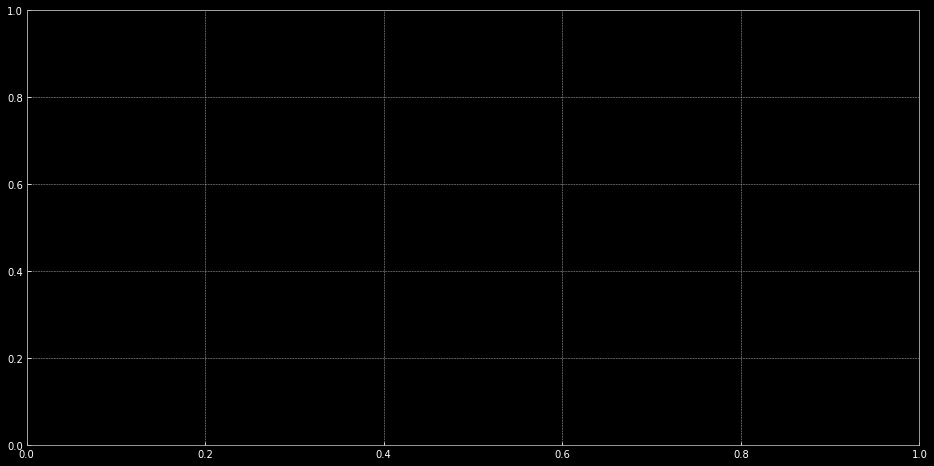

In [20]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');